In [1]:
import src.dataloader
import torch
import pathlib

device = torch.device("cuda")

dataloader = src.dataloader.load_train_data(pathlib.Path("C:/Users/imeho/Documents/DataSets/InstantPINF/ScalarReal"),
                                            "train",
                                            device=device)
image_batch = next(iter(dataloader))

print(f'image device: {image_batch["image"].device}')
memory_image_cuda = image_batch['image'].element_size() * image_batch['image'].numel()
print(f'Memory of image: {memory_image_cuda / 1024 / 1024:.2f} MB')

Caching all 480 images.

Output()

image device: cuda:0
Memory of image: 11390.62 MB


In [2]:
from nerfstudio.model_components.ray_samplers import UniformSampler
from nerfstudio.model_components.scene_colliders import NearFarCollider

collider = NearFarCollider(near_plane=1.1, far_plane=1.5).to(device)
sampler_uniform = UniformSampler(num_samples=192).to(device)

In [3]:
import src.encoder
import taichi as ti
import numpy as np

ti.init(arch=ti.cuda)
xyzt_encoder = src.encoder.HashEncoderHyFluid(
    min_res=np.array([16, 16, 16, 16]),
    max_res=np.array([256, 256, 256, 128]),
    num_scales=16,
    max_params=2 ** 19,
)
xyzt_encoder.to(device)

[Taichi] version 1.7.2, llvm 15.0.1, commit 0131dce9, win, python 3.11.0
[Taichi] Starting on arch=cuda


HashEncoderHyFluid()

In [4]:
from nerfstudio.field_components.mlp import MLP
import src.radam

mlp_base = MLP(
    in_dim=xyzt_encoder.num_scales * xyzt_encoder.features_per_level,
    num_layers=2,
    layer_width=64,
    out_dim=1,
    out_activation=torch.nn.ReLU(),
)
mlp_base.to(device)
learned_rgb = torch.nn.Parameter(torch.tensor([0.0], device=device))

grad_vars = list(mlp_base.parameters()) + [learned_rgb]
embedding_params = list(xyzt_encoder.parameters())

optimizer = src.radam.RAdam([
    {'params': grad_vars, 'weight_decay': 1e-6},
    {'params': embedding_params, 'eps': 1e-15}
], lr=0.01, betas=(0.9, 0.99))

In [5]:
raw2alpha = lambda raw, dists, act_fn=torch.nn.functional.relu: 1. - torch.exp(-act_fn(raw) * dists)

In [6]:
import nerfstudio.data.pixel_samplers
import nerfstudio.model_components.ray_generators

ps = nerfstudio.data.pixel_samplers.PixelSamplerConfig(num_rays_per_batch=1024).setup()
rg = nerfstudio.model_components.ray_generators.RayGenerator(dataloader.dataset.cameras).to(device)

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


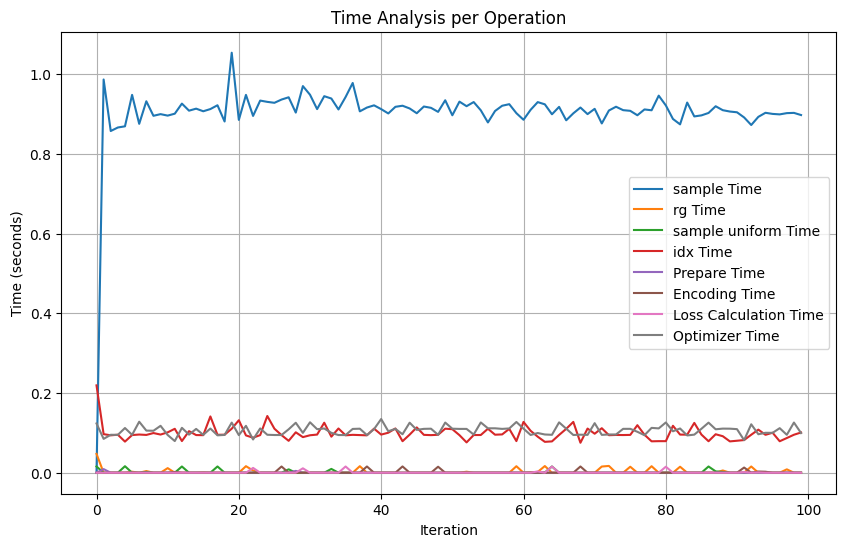

In [11]:
import nerfstudio.model_components.losses
import tqdm
import time
import matplotlib.pyplot as plt

# 初始化 MSE 损失函数
rgb_loss = nerfstudio.model_components.losses.MSELoss()

# 定义列表存储时间
sample_times = []
rg_times = []
sample_uniform_times = []
idx_times = []
pre_times = []
encoding_times = []
loss_calc_times = []
optimizer_times = []

# 主循环
for i in tqdm.tqdm(range(100)):
    # 记录编码时间
    start = time.time()
    batch = ps.sample(image_batch)
    end = time.time()
    sample_times.append(end - start)

    start = time.time()
    ray_bundle = rg(batch['indices'])
    collider(ray_bundle)
    end = time.time()
    rg_times.append(end - start)

    start = time.time()
    ray_samples_uniform = sampler_uniform(ray_bundle)
    positions = ray_samples_uniform.frustums.get_positions()
    end = time.time()
    sample_uniform_times.append(end - start)

    start = time.time()
    frames = image_idx_to_frame(image_indices=batch['indices'][:, 0],
                                all_frames=dataloader.dataset.metadata['all_frames'])
    end = time.time()
    idx_times.append(end - start)

    start = time.time()
    frames_expanded = frames.view(positions.shape[0], 1, 1).expand(-1, positions.shape[1], -1)
    xyzt = torch.cat((positions, frames_expanded), dim=-1)
    xyzt_flat = xyzt.reshape(-1, 4)
    end = time.time()
    pre_times.append(end - start)

    start = time.time()
    xyzt_encoded = xyzt_encoder(xyzt_flat)
    end = time.time()
    encoding_times.append(end - start)  # 存储编码耗时

    # 记录损失计算时间
    start = time.time()
    raw_flat = mlp_base(xyzt_encoded)
    raw = raw_flat.reshape(xyzt.shape[0], xyzt.shape[1], raw_flat.shape[-1])
    dists = ray_samples_uniform.deltas
    rgb = torch.ones(3, device=device) * (0.6 + torch.tanh(learned_rgb) * 0.4)
    alpha = raw2alpha(raw[..., -1], dists[..., -1])
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1), device=device), 1. - alpha + 1e-10], -1),
                                    -1)[:, :-1]
    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    loss = rgb_loss(rgb_map, batch['image'])
    end = time.time()
    loss_calc_times.append(end - start)  # 存储损失计算耗时

    # 记录优化时间
    start = time.time()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    new_lrate = 5e-4 * (0.1 ** (i / 250))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate

    end = time.time()
    optimizer_times.append(end - start)  # 存储优化耗时

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(sample_times, label='sample Time')
plt.plot(rg_times, label='rg Time')
plt.plot(sample_uniform_times, label='sample uniform Time')
plt.plot(idx_times, label='idx Time')
plt.plot(pre_times, label='Prepare Time')
plt.plot(encoding_times, label='Encoding Time')
plt.plot(loss_calc_times, label='Loss Calculation Time')
plt.plot(optimizer_times, label='Optimizer Time')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Time Analysis per Operation')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def image_idx_to_frame(image_indices, all_frames):
    cumulative_frames = torch.cumsum(torch.tensor([0] + all_frames[:-1], device=image_indices.device), dim=0)
    result = []
    for image_idx in image_indices:
        video_idx = torch.searchsorted(cumulative_frames, image_idx, right=True) - 1
        frame_in_video = image_idx - cumulative_frames[video_idx]
        result.append(frame_in_video.item())
    return torch.tensor(result, device=image_indices.device)